# Trial and Error Fun with Model Optimization

#### Import libraries and modules

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plotly import express as px

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, recall_score, roc_auc_score, precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import FalseNegatives, AUC, Precision

#### Import dataMinMaxScaler

In [5]:
data = pd.read_csv('../data/clean_data.csv')

In [6]:
data.head(3)

,file_path,file_name,label,shape,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,95012,95013,95014,95015,95016,95017,95018,95019,95020,95021,95022,95023,95024,95025,95026,95027,95028,95029,95030,95031,95032,95033,95034,95035,95036,95037,95038,95039,95040,95041,95042,95043,95044,95045,95046,95047,95048,95049,95050,95051
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)",162,115,50,163,115,51,169,119,56,171,121,58,169,117,54,170,117,54,170,116,54,170,114,53,171,118,53,172,117,52,173,118,51,177,121,54,...,68,190,129,66,186,124,62,186,121,60,192,125,66,194,123,67,194,122,67,184,107,60,169,87,44,159,72,32,164,73,34,167,72,34,168,71,33,163,67,28
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)",144,108,56,145,109,57,147,111,59,151,116,62,154,119,65,153,118,63,149,114,58,150,115,59,153,118,62,150,115,57,153,113,57,159,118,62,...,31,136,83,31,132,79,27,132,76,25,132,75,24,132,73,23,131,71,21,130,67,18,131,67,19,136,71,23,140,73,25,145,75,26,145,75,26,146,76,27
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)",254,155,26,254,156,27,254,158,28,253,158,28,254,159,29,255,161,31,255,164,32,253,167,32,254,166,32,255,165,32,255,165,32,255,165,32,...,53,227,146,55,221,139,52,216,131,48,214,131,47,215,133,46,215,135,48,217,137,48,220,142,51,220,143,51,220,146,51,220,146,51,220,146,52,219,146,52


#### Define X and y for model

In [7]:
X = data.drop(columns=['file_path', 'file_name', 'label', 'shape'])
y = data['label']

In [8]:
# scale X data to be between 0 and 1
X = X.astype('float32')/255

In [9]:
# convert X into a numpy array where each element 
# is a figure that has the dimensions (178, 178, 3)

image_vectors = np.array(X) # each element is a vector of pixel values

X_array = np.array([row.reshape(178, 178, 3) for row in image_vectors])

X_array.shape # needs to be (705, 178, 178, 3)
              # (number of images, (pixel xy dimensions), RGB)

(705, 178, 178, 3)

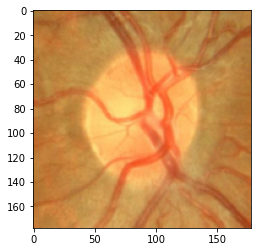

In [10]:
# Check to make sure image is not distorted
plt.imshow(X_array[0]);

In [11]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_array, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

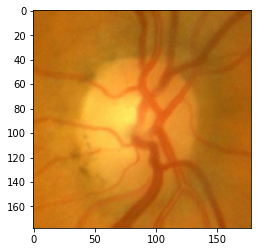

In [12]:
# checking again to make sure images are intact
plt.imshow(X_train[0]);

In [13]:
y_test

105    0
499    1
49     0
610    1
484    1
      ..
362    1
321    1
459    1
87     0
357    1
Name: label, Length: 141, dtype: int64

#### Define Model

In [14]:
# test 1: change filters for conv layer 1 from 16 to 32 --> improved recall from 0.92 to 0.98; decreased auc from 0.88 to 0.86
# test 2: change filters for conv layer 1 from 32 to 36 --> nope
# test 3: keep filters for conv layer 1 at 32, change kernal size frm (3, 3) to (4, 4) --> improved things dramatically: 
#         recall: 1.0, roc_auc: 0.9
# test 4: add second convolution layer: changed everything!! Keeping this one

cnn = Sequential()

# convolution layer 1
cnn.add(Conv2D(filters=32,
              kernel_size=(4, 4),
              activation='relu',
              input_shape=(178, 178, 3)
              ))
# pooling layer 1
cnn.add(MaxPooling2D(pool_size=(2, 2)))


# convolution layer 2
cnn.add(Conv2D(filters=32,
              kernel_size=(4, 4),
              activation='relu',
              input_shape=(178, 178, 3)
              ))
# pooling layer 2
cnn.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
cnn.add(Flatten())

#dense layers
cnn.add(Dense(units=128, activation='relu'))

#output layer
cnn.add(Dense(units=1, activation='sigmoid'))

# early stopping
early_stop = EarlyStopping(patience=5)

# Compile model
cnn.compile(loss='bce', 
            optimizer='adam', 
            metrics=['accuracy', FalseNegatives(), Precision(), AUC()])

# Fit model on training data
history = cnn.fit(X_train, y_train,
               batch_size=256,
               epochs=20,
               validation_data=(X_test, y_test),
               callbacks=[early_stop])

Epoch 1/20
3/3 [==============================] - 12s 3s/step - loss: 2.9685 - accuracy: 0.4628 - false_negatives_1: 174.0000 - precision_1: 0.5257 - auc_1: 0.4566 - val_loss: 1.2005 - val_accuracy: 0.4397 - val_false_negatives_1: 79.0000 - val_precision_1: 0.0000e+00 - val_auc_1: 0.6491
Epoch 2/20
3/3 [==============================] - 8s 2s/step - loss: 0.9783 - accuracy: 0.4858 - false_negatives_1: 290.0000 - precision_1: 1.0000 - auc_1: 0.5913 - val_loss: 0.6469 - val_accuracy: 0.5603 - val_false_negatives_1: 0.0000e+00 - val_precision_1: 0.5603 - val_auc_1: 0.8184
Epoch 3/20
3/3 [==============================] - 8s 2s/step - loss: 0.6386 - accuracy: 0.5621 - false_negatives_1: 0.0000e+00 - precision_1: 0.5621 - auc_1: 0.8329 - val_loss: 0.6657 - val_accuracy: 0.5603 - val_false_negatives_1: 0.0000e+00 - val_precision_1: 0.5603 - val_auc_1: 0.7943
Epoch 4/20
3/3 [==============================] - 9s 2s/step - loss: 0.6052 - accuracy: 0.6277 - false_negatives_1: 1.0000 - precision_

In [103]:
# uncomment below to save model to directory
# cnn.save('../models/model_03_auc93')

INFO:tensorflow:Assets written to: ../models/model_03_auc93\assets


In [15]:
preds = cnn.predict(X_test)

**Plot distribution of predicted probabilities to get a sense of how separated the two groups are**

In [112]:
# create dataframe to make plotting easier
predictions_df = pd.DataFrame(y_test)
predictions_df['preds'] = preds

# replace 1 and 0 with strings indicating class
predictions_df['label'].replace({1:'Glaucoma', 0:'Healthy'}, inplace=True)

# uncomment below to save predictions to file
# predictions_df.to_csv('../data/test_predictions.csv', index=False)

Text(0.35, 3.1, 'threshold for\nclassification')

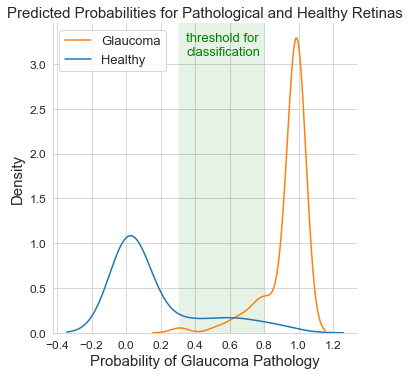

In [183]:
# predictions_df = pd.read_csv('../data/test_predictions.csv')

sns.set_style('whitegrid')
sns.displot(data=predictions_df, x='preds', hue='label', kind='kde', height=5, legend=False);
# plt.axvline(0.65, color='green', linestyle='--')
plt.title('Predicted Probabilities for Pathological and Healthy Retinas', size=15);
plt.xlabel('Probability of Glaucoma Pathology', size=15)
plt.ylabel('Density', size=15)
plt.legend(['Glaucoma', 'Healthy'], fontsize=13);
plt.xticks(size=12)
plt.yticks(size=12);

# generate a rectangle area where the potential threshold for predicted probability would be 
left, bottom, width, height = (0.3, 0, 0.5, 3.5)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect)
plt.text(0.35, 3.1,'threshold for\nclassification',fontsize=13, color="green")


# uncomment below to save figure
# plt.savefig('../figures/prob_distribution.png', bbox_inches='tight', dpi=300)

**Determine what the optimal threshold for predicted probability is that maximizes performance metrics of the model**

First, I calculate all metrics (recall (for false-negatives), precision(for false-positives), accuracy (for overall classifictation since classes are more or less balanced), and auc_roc), for all values of threshold between 0.3 and 0.8. I picked these values because this is the area inbetween the two curves. 

In [184]:
recall = []
precision = []
auc = []
accuracy = []
thresh = []
for th in np.linspace(0.3, 0.8, 20):
    y_pred = [0 if p<th else 1 for p in preds]
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    thresh.append(th)
metrics_df = pd.DataFrame(dict(threshold=thresh,
                              recall=recall,
                              precision=precision,
                              auc=auc,
                              accuracy=accuracy))

Visualize the dataframe of values

In [185]:
metrics_df.sort_values('auc', ascending=False).head()

,threshold,recall,precision,auc,accuracy
12,0.615789,0.962025,0.926829,0.932626,0.936170
17,0.747368,0.911392,0.960000,0.931503,0.929078
11,0.589474,0.974684,0.916667,0.930890,0.936170
16,0.721053,0.924051,0.948052,0.929767,0.929078
15,0.694737,0.936709,0.936709,0.928032,0.929078


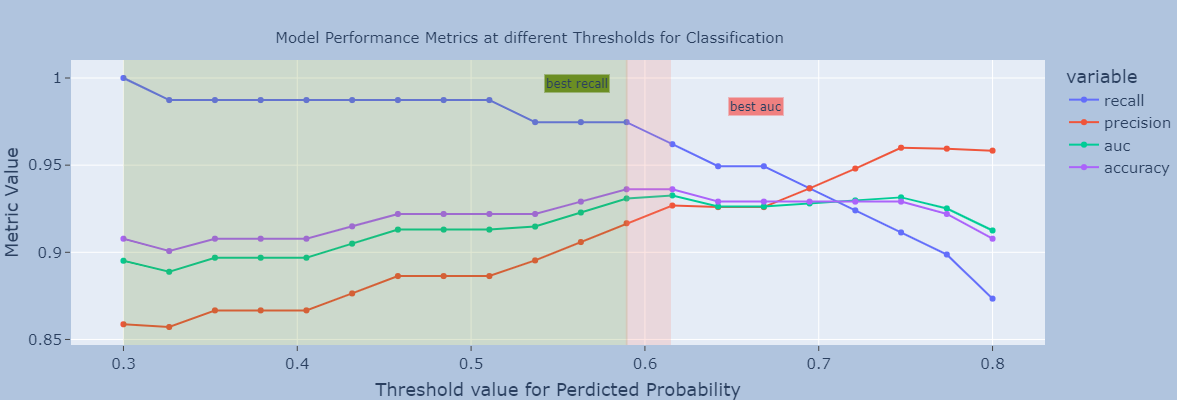

In [277]:
# use melt to convert the dataframe with different columns for each metric into a 
# dataframe with a single column of metric values and a second column of metric labels.
# This makes it easy to plot the data in plotly. 

df = pd.melt(metrics_df, id_vars='threshold', value_vars=metrics_df.columns[:])

fig = px.line(df, x='threshold', y='value', color='variable')

fig.update_layout(width=600, 
                  height=400,
                  title_text='Model Performance Metrics at different Thresholds for Classification',
                  title_y=0.92,
                  title_x=0.45,
                  margin=dict(l=10, r=0, t=60, b=10),
                  paper_bgcolor="lightsteelblue",
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15)
                 )

# set axes labels
fig.update_xaxes(title='Threshold value for Perdicted Probability', title_font_size=18, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Metric Value', title_font_size=18, tickfont_size=15, ticks='outside')

fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")

# add retangles
fig.add_vrect(x0=0.3, x1=0.59, line_width=0, fillcolor="olivedrab", opacity=0.2, annotation=dict(text='best recall', x=0.58, y=0.95, bgcolor='olivedrab'))
fig.add_vrect(x0=0.589, x1=0.615, line_width=0, fillcolor="salmon", opacity=0.2, annotation=dict(text='best auc', x=0.68, y=0.87, bgcolor='lightcoral'))

# # add marker at position where two shaded areas overlap 
# fig.add_vline(x=0.589, line_width=2, line_dash="dash", line_color="mediumblue", annotation=dict(text='best threshold', x=0.55, y=0.3, bgcolor='lightblue'))
# # fig.add_scatter(x=[0.589, 0.589], 
# #                 y=[1, 0.85], 
# #                 name='best threshold', 
# #                 marker=dict(size=2, 
# #                             line=dict(width=2),
# #                             color='blue', 
# #                             symbol="circle-dot"))


fig.show()

**Pick a threshold using the interactive plotly plot**
From the figure above, best threshold appears to be 0.589

In [284]:
# generate a y_pred variable which is 0 (or Healthy) for all observations that have a predicted probability of less than the threshold
# and a value of 1 (or Glaucoma) for all observations with a predicted probability of greater than the threshold
y_pred = [0 if p<0.589 else 1 for p in preds]
y_pred_train = [0 if p<0.589 else 1 for p in cnn.predict(X_train)]

In [287]:
# calculate metrics for test and train sets

pd.DataFrame(index=['recall', 'accuracy', 'roc_auc', 'precision'], 
             data={'test set': [recall_score(y_test, y_pred),
                        accuracy_score(y_test, y_pred),
                        roc_auc_score(y_test, y_pred),
                        precision_score(y_test, y_pred)],
                  'train set': [recall_score(y_train, y_pred_train),
                        accuracy_score(y_train, y_pred_train),
                        roc_auc_score(y_train, y_train),
                        precision_score(y_train, y_train)]})

,test set,train set
recall,0.974684,0.911672
accuracy,0.936170,0.932624
roc_auc,0.930890,1.000000
precision,0.916667,1.000000


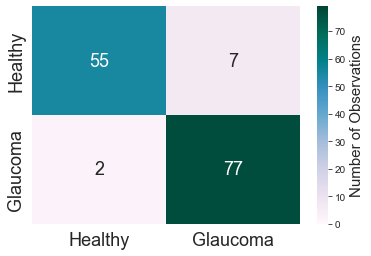

In [334]:
fig = sns.heatmap(confusion_matrix(y_test, y_pred), 
                  annot=True, 
                  annot_kws={"size": 18},
                  cbar_kws={'label': 'Number of Observations'},
                  xticklabels=['Healthy', 'Glaucoma'], 
                  yticklabels=['Healthy', 'Glaucoma'],
                  vmin=0, vmax=79, 
                  cmap='PuBuGn');

fig.figure.axes[-1].yaxis.label.set_size(15)
fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 18)
fig.set_yticklabels(fig.get_ymajorticklabels(), fontsize = 18);

Plotly Figure

In [114]:
glauc = predictions_df[predictions_df['label']=='Glaucoma']['preds']
healthy = predictions_df[predictions_df['label']=='Healthy']['preds']

In [120]:
# to plot a point, we know the probability value for the figure, ex 0.2

def find_y(val, fig):
    threshold = 0.589 # threshold of predicted probability for classification
    if val > threshold: # model would predict as 'Glaucoma'
        arr_0 = np.array(fig.data[0]['x'])
        ind_0 = abs(val - arr_0).argmin()
        # min_0 = arr_0[ind_0]
        y = fig.data[0]['y'][ind_0] 
    else:    # model would predict as 'Healthy'
        arr_1 = np.array(fig.data[1]['x'])
        ind_1 = abs(val - arr_1).argmin()
        # min_1 = arr_1[ind_1]
        y = fig.data[1]['y'][ind_1]
    
    return y

0.6199856

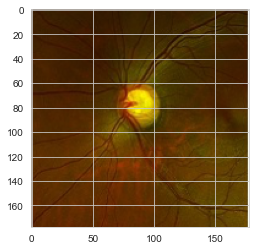

In [116]:
# make prediction on new image that the model has not seen
from PIL import Image

img = '../data/test_images/LA_left_eye.jpg'
image_data = np.asarray(Image.open(img).resize((178,178))) # resize to a size the network can accept and convert to np.array
image_data = image_data.astype('float32')/255 # normalize pixel values to [0, 1]
plt.imshow(image_data)
image_data = image_data.reshape(1, 178, 178, 3) # reshape array to appropriate shape for network 
prediction = cnn.predict(image_data)[0][0]
prediction

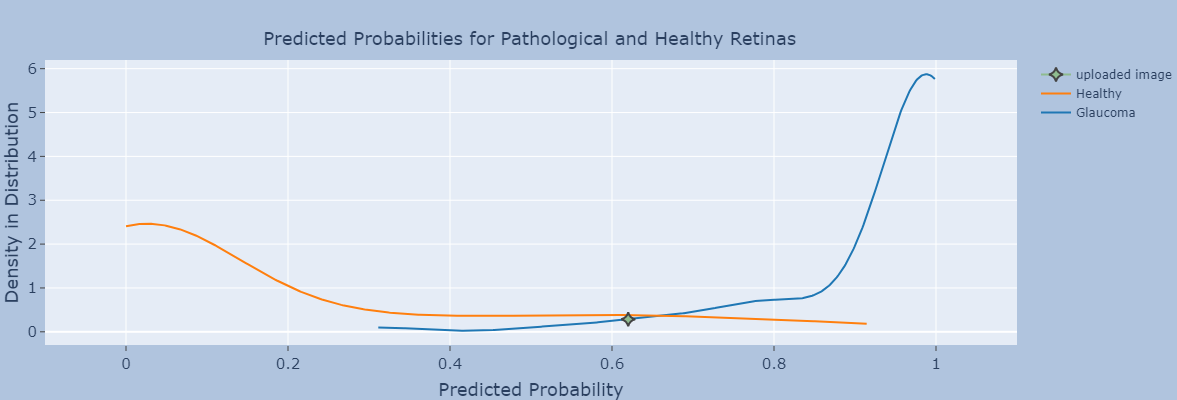

In [152]:
var = [glauc, healthy]
labels = ['Glaucoma', 'Healthy']

# generate figure using true labels
fig = ff.create_distplot(var, 
                         labels,
                         # bin_size=0.01,
                         show_hist=False, 
                         show_rug=False)
# set size and title
fig.update_layout(width=500, 
                  height=400,
                  title_text='Predicted Probabilities for Pathological and Healthy Retinas',
                  title_y=0.92,
                  title_x=0.45,
                  xaxis_range=[-0.1, 1.1],
                  margin=dict(l=10, r=0, t=60, b=10),
                  paper_bgcolor="lightsteelblue",
                  legend=dict(font=dict(size=12)),
                  title_font=dict(size=18)
                 )

# set axes labels
fig.update_xaxes(title='Predicted Probability', title_font_size=18, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density in Distribution', title_font_size=18, tickfont_size=15, ticks='outside')

# add marker at position matching predicted probability of the uploaded image 
fig.add_scatter(x=[round(prediction, 2)], 
                y=[find_y(round(prediction, 2),fig)], # use helper function 'find_y' to determine what the y coordinate for the marker should be
                name='uploaded image', 
                marker=dict(size=10, 
                            line=dict(width=2),
                            color='darkseagreen', 
                            symbol="star-diamond"))



fig.show()